<center>
    <h1></h1>
    <h1>Addis Ababa University</h1>
    <h1>Addis Ababa Institute of Technology</h1>
    <h2>School of Information Technology and Engineering</h2>
    <h2>Deep Learning</h2>
    <h4>Sentiment Analysis with LSTM</h4>
<br><br>
<div style="max-width:600px;margin:auto">
    <table>
  <tr >
    <th style="text-align:left">Name</th>
    <th style="text-align:left">ID</th>
  </tr>
  <tr>
    <td style="text-align:left">Bisrat Walle</td>
    <td style="text-align:left">UGR/4425/12</td>
  </tr>
</table>
</div>
</center>
<br><br>
<h3 style="text-align:right">Submitted to: Eyob S.</h3>
<hr style="border:1px solid green">

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.vocab import GloVe
from collections import Counter
from torchtext.vocab import vocab
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

## Load and Prepare GloVe Embeddings
Loading GloVe embeddings to use as the pretrained word vectors for our model's embedding layer.

In [ ]:
# Load the GloVe embeddings (300-dimensional vectors in this example)
glove = GloVe(name='840B', dim=300)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                                
  1%|          | 16302/2196017 [00:02<06:28, 5614.47it/s]

In [4]:
# Directly use GloVe's stoi as our vocab
vocab = glove.stoi

# Tokenize and encode sentences
tokenizer = get_tokenizer("basic_english")
def tokenize_and_encode(sentences):
    return [[vocab.get(token, vocab.get("<unk>")) for token in tokenizer(sentence)] for sentence in sentences]

## Define Model and Dataset
Here we define the sentiment analysis model using BiLSTM and a custom dataset class to handle the tokenization and encoding of text data.

In [5]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(SentimentBiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) if self.bidirectional else self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output
    

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, max_length=50):
        self.encodings = tokenize_and_encode(texts)
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.encodings)
    
    def __getitem__(self, idx):
        # Use vocab.get(token, 1) to use index 1 for <unk>
        encoding = [vocab.get(token, 1) for token in self.encodings[idx][:self.max_length]]  # +2 shift not needed now
        padding_length = self.max_length - len(encoding)
        if padding_length > 0:
            encoding += [0] * padding_length  # Use 0 for <pad>
        return torch.tensor(encoding, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

## Load Datasets
Loading the training, validation, and test datasets using the `datasets` library.

In [12]:
# Load datasets
train_dataset = load_dataset("carblacac/twitter-sentiment-analysis", split="train")
test_dataset = load_dataset("carblacac/twitter-sentiment-analysis", split="test")
valid_dataset = load_dataset("carblacac/twitter-sentiment-analysis", split="validation")

# Prepare dataset variables
train_texts = train_dataset['text']
train_labels = train_dataset['feeling']
test_texts = test_dataset['text']
test_labels = test_dataset['feeling']
valid_texts = valid_dataset['text']
valid_labels = valid_dataset['feeling']

# Create datasets
train_data = SentimentDataset(train_texts, train_labels)
test_data = SentimentDataset(test_texts, test_labels)
valid_data = SentimentDataset(valid_texts, valid_labels)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)
valid_loader = DataLoader(valid_data, batch_size=32)

In [ ]:
type(train_dataset)

In [13]:
embedding_dim = 300  # Dimension of GloVe vectors

# Initialize embedding matrix with zeros for all words plus extra rows for <pad> and <unk>
vocab_size = len(vocab) + 3  # +2 for <pad> and <unk>
embedding_matrix = torch.zeros(vocab_size, embedding_dim)

# Fill the embedding matrix with GloVe vectors, leaving index 0 for <pad> and 1 for <unk>
for word, idx in vocab.items():
    embedding_matrix[idx + 2] = glove.vectors[glove.stoi[word]]  # Shift by 2 to accommodate <pad> and <unk>

# Use zeros for <pad> (index 0) and mean of all vectors or a random vector for <unk> (index 1)
embedding_matrix[1] = torch.mean(glove.vectors, dim=0)  # or torch.randn(embedding_dim) for a random vector

# Make sure to convert embedding_matrix to FloatTensor if not already
embedding_matrix = embedding_matrix.float()
model = SentimentBiLSTM(embedding_matrix=embedding_matrix, hidden_dim=10, output_dim=1, num_layers=10, bidirectional=True, dropout=0.2)

## Model Training and Evaluation
Setting up the training loop, including loss function, optimizer, and the loop itself for training and evaluating the model.

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Moving model to GPU if available
model.to(device)

# Function to calculate accuracy
def calculate_accuracy(predictions, labels):
    probs = torch.sigmoid(predictions)
    preds = (probs > 0.5).float()
    accuracy = (preds == labels).float().mean()
    return accuracy

# Lists to track per-epoch metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0
    
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        accuracy = calculate_accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(total_accuracy / len(train_loader))
    
    # Validation
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    
    with torch.no_grad():
        for texts, labels in valid_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            accuracy = calculate_accuracy(predictions, labels)
            
            total_val_loss += loss.item()
            total_val_accuracy += accuracy.item()
    
    valid_losses.append(total_val_loss / len(valid_loader))
    valid_accuracies.append(total_val_accuracy / len(valid_loader))
    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}')

Epoch 1: Train Loss: 0.6975, Train Accuracy: 0.5002, Valid Loss: 0.6977, Valid Accuracy: 0.4983


## Visualize Training Progress
Plotting training and validation loss and accuracy over epochs to visually assess how the model is learning.

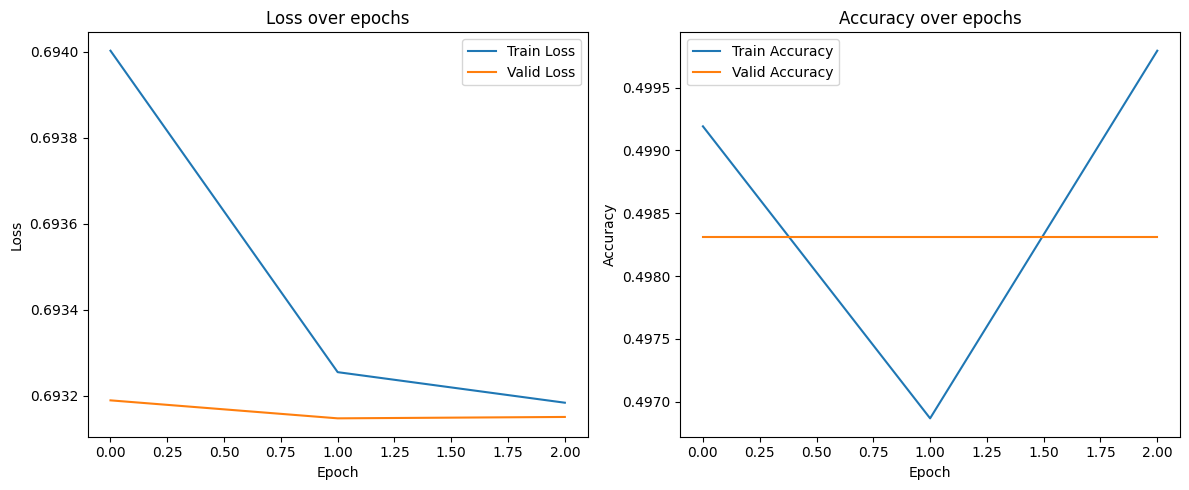

In [10]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Test the Model
Now that the model has been trained and validated, it's time to test its performance on unseen data. This step is crucial to evaluate the generalization ability of the model. We use the test dataset loaded earlier for this purpose

In [11]:
# Evaluate on test data
model.eval()
total_test_loss = 0
total_test_accuracy = 0

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        accuracy = calculate_accuracy(predictions, labels)
        
        total_test_loss += loss.item()
        total_test_accuracy += accuracy.item()

avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}')

Test Loss: 0.6931, Test Accuracy: 0.5004


In [ ]:
checkpoint = {'model': SentimentBiLSTM(embedding_matrix=embedding_matrix, hidden_dim=10, output_dim=1, num_layers=10, bidirectional=True, dropout=0.2),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)